<a href="https://colab.research.google.com/github/nabiafshan/fastai/blob/main/01_Is_it_a_bird%3F_Is_it_a_plane%3F_It's_superman!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd

/content


Here's the process
* Choose categories- bird, plane, superman
* Download 1 image for each and check they're ok
* Download 30 images for each into directories named by category
* Check images are valid
* Download pre-trained model
* Feed dir into model, fine tune, check performance

In [ ]:
!pip install -Uqq fastai duckduckgo_search

     |████████████████████████████████| 96 kB 7.0 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

## Data

### Searching for images

In [ ]:
bird = ddg_images('bird', max_results=2)

* Bird is a list of dicts
* wrap inside [L](https://fastcore.fast.ai/foundation.html#l)
* use `.itemgot('image')` on L to extract the urls only


In [ ]:
bird

[{'title': 'Pair these bird events with Great Backyard Bird Count - pennlive.com',
  'image': 'https://www.pennlive.com/resizer/UeXGnWaOE07lC4n_J5lJ0a1M-_M=/1280x0/smart/advancelocal-adapter-image-uploads.s3.amazonaws.com/image.pennlive.com/home/penn-media/width2048/img/entertainment_impact/photo/shutterstock-58364638jpg-6932548563f01558.jpg',
  'thumbnail': 'https://tse1.mm.bing.net/th?id=OIP.tAh4IvhbxtzpJUCMwC-djQHaGe&pid=Api',
  'url': 'https://www.pennlive.com/entertainment/2015/02/pair_these_bird_events_with_gr.html',
  'height': 1118,
  'width': 1280,
  'source': 'Bing'},
 {'title': "Help Count Birds for Science during Audubon's Annual Christmas Bird ...",
  'image': 'https://www.mississippiriverdelta.org/files/2015/12/BUFH-wing-feathers.jpg',
  'thumbnail': 'https://tse2.mm.bing.net/th?id=OIP.1xYUOvqR7iH9FMoKBawtIAHaF1&pid=Api',
  'url': 'https://mississippiriverdelta.org/help-count-birds-for-science-during-audubons-annual-christmas-bird-count/',
  'height': 1340,
  'width': 170

In [ ]:
L(bird).itemgot('image')

(#2) ['https://www.pennlive.com/resizer/UeXGnWaOE07lC4n_J5lJ0a1M-_M=/1280x0/smart/advancelocal-adapter-image-uploads.s3.amazonaws.com/image.pennlive.com/home/penn-media/width2048/img/entertainment_impact/photo/shutterstock-58364638jpg-6932548563f01558.jpg','https://www.mississippiriverdelta.org/files/2015/12/BUFH-wing-feathers.jpg']

Build `search_images` using these

In [ ]:
def search_images(keyword, max_images=30):
    return L(ddg_images(keyword, max_results=max_images)).itemgot('image')

In [ ]:
url = search_images('flying bird', 1)
url

(#1) ['http://1.bp.blogspot.com/-6anwlEoD-Ec/UmvgxLKbxsI/AAAAAAAAZhQ/z64F1RGv7iU/s1600/Flying+Birds+Wallpapers+%25283%2529.jpg']

### Downloading and viewing single images

In [ ]:
from fastdownload import download_url
download_url(url[0], dest='bird.jpg', show_progress=False)

Path('bird.jpg')

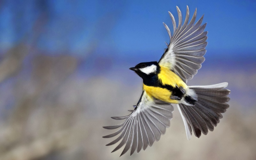

In [ ]:
from fastai.vision.all import *
im = Image.open('bird.jpg')
im.to_thumb(256,256)

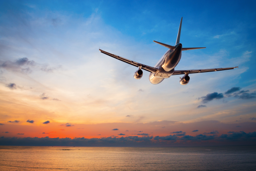

In [ ]:
download_url(search_images('flying plane', 1)[0], dest='plane.jpg', show_progress=False)
Image.open('plane.jpg').to_thumb(256, 256)

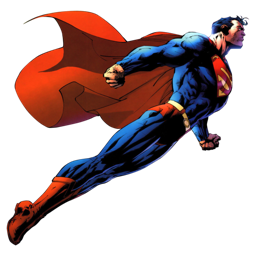

In [ ]:
download_url(search_images('flying superman', 1)[0], dest='superman.jpg', show_progress=False)
Image.open('superman.jpg').to_thumb(256, 256)

### Download many images

In [ ]:
import os

In [ ]:
searches = ['bird', 'plane', 'superman']
path = Path('is_that_a')

for s in searches:
    dest = (path/s)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'flying {s}'))
    resize_images(path/s, max_size=400, dest=path/s)

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

## Fine-tune model

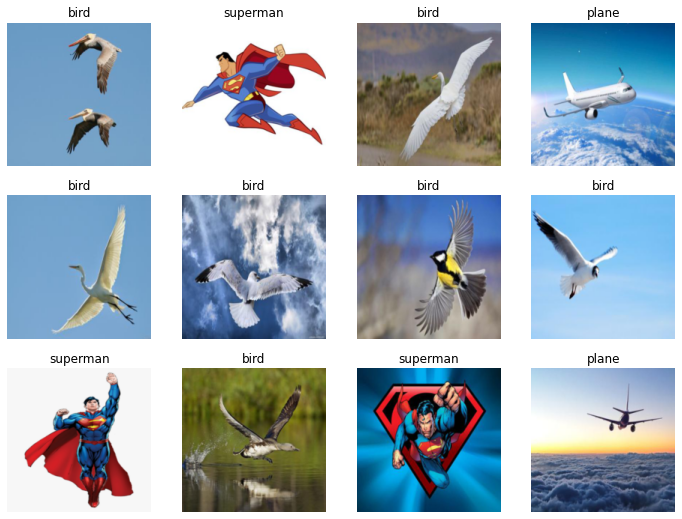

In [ ]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                get_items=get_image_files,
                splitter=RandomSplitter(valid_pct=0.2, seed=42),
                get_y=parent_label,
                item_tfms=[Resize(192, method='squish')] 
                ).dataloaders(path, bs=32)
dls.show_batch(max_n=12)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.123390,2.041406,0.647059,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.009901,0.819089,0.411765,00:11
1,0.627152,0.066545,0.000000,00:13
2,0.439642,0.016115,0.000000,00:18


## Evaluate

In [ ]:
is_that_a,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"That is a: {is_that_a}.")
print(f"Probability: {probs[0]:.4f}")

That is a: bird.
Probability: 0.9775


In [ ]:
is_that_a,_,probs = learn.predict(PILImage.create('plane.jpg'))
print(f"That is a: {is_that_a}.")
print(f"Probability: {probs[1]:.4f}")

That is a: plane.
Probability: 0.9995


In [ ]:
is_that_a,_,probs = learn.predict(PILImage.create('superman.jpg'))
print(f"That is a: {is_that_a}.")
print(f"Probability: {probs[2]:.4f}")

That is a: superman.
Probability: 0.9994
